# Part I - The Streaming Era Divide: Exploratory Analysis

## by Shay Harding

## Introduction

The rise of streaming platforms has transformed how audiences consume movies. Services like Netflix, Hulu, Disney+, and Amazon Prime have built vast libraries by licensing theatrical releases alongside original content. But which theatrical movies end up on streaming platforms, and do they differ systematically from films that remain theatrical-only?

This exploratory analysis investigates 10,835 theatrical movies released between 1960 and 2015, merged from TMDb and IMDb sources and integrated with streaming availability data from four major platforms. The dataset includes financial metrics (inflation-adjusted budget, revenue, and ROI), ratings from both TMDb and IMDb, genres, runtime, and streaming availability flags.

**Key Questions to Explore:**
- Which decades and genres dominate streaming catalogs?
- Do movies that ended up on streaming differ financially from theatrical-only releases?
- How do streaming platforms differ in their curation strategies?
- What characteristics predict whether a theatrical release will appear on streaming?

This investigation builds on previous analysis of theatrical movie performance by adding the streaming dimension, allowing us to understand how the industry's distribution landscape has evolved.

## Preliminary Wrangling

In [1]:
# import all packages and set plots to be embedded inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from matplotlib.ticker import FuncFormatter

# Magic word for inline visualizations
%matplotlib inline

# Set default figure size for better readability
sb.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

DATA_PATH = 'data'

def show_df_brief(df):
    """Show basic dataframe information"""
    display(df.head())
    display(df.info())
    
def currency_formatter(x, pos):
    """Fix axis labels to show dollar amounts instead of scientific notation"""
    if x >= 1:
        return f'${x:.0f}M'
    else:
        return f'${x:.1f}M'

### Load Datasets

In [2]:
xmdb_df = pd.read_csv(f'{DATA_PATH}/imdb_tmdb_theatrical_movies_merged_clean.csv')
streaming_df = pd.read_csv(f'{DATA_PATH}/streaming_movies_merged_clean.csv')

#### Show Basic Dataset Information (xmdb_df)

In [3]:
show_df_brief(xmdb_df)

,budget,revenue,original_title,tmdb_votes,tmdb_rating,release_year,imdb_rating,imdb_votes,genres,runtime,...,budget_adj_2024,revenue_adj_2024,roi,profit_margin,on_netflix,on_hulu,on_disney,on_amazon,on_streaming,streaming_platforms
0,150000000.0,1.513529e+09,Jurassic World,5562,6.5,2015,6.9,718366.0,"('Adventure', 'Action', 'Thriller', 'Science F...",124.0,...,1.985414e+08,2.003320e+09,909.019207,90.089386,False,False,False,False,False,0
1,150000000.0,3.784364e+08,Mad Max: Fury Road,6185,7.1,2015,8.1,1189406.0,"('Adventure', 'Action', 'Thriller', 'Science F...",120.0,...,1.985414e+08,5.009018e+08,152.290903,60.363216,False,False,False,False,False,0
2,110000000.0,2.952382e+08,Insurgent,2480,6.3,2015,6.2,268250.0,"('Adventure', 'Action', 'Science Fiction', 'Th...",119.0,...,1.455970e+08,3.907800e+08,168.398365,62.741949,False,False,False,False,False,0
3,200000000.0,2.068178e+09,Star Wars: The Force Awakens,5292,7.5,2015,7.7,1013886.0,"('Adventure', 'Action', 'Fantasy', 'Science Fi...",136.0,...,2.647218e+08,2.737459e+09,934.089113,90.329654,False,False,False,False,False,0
4,190000000.0,1.506249e+09,Furious 7,2947,7.3,2015,7.1,434109.0,"('Action', 'Thriller', 'Crime')",137.0,...,2.514857e+08,1.993685e+09,692.762821,87.385887,False,False,False,False,False,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10835 entries, 0 to 10834
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   budget               5166 non-null   float64
 1   revenue              4849 non-null   float64
 2   original_title       10835 non-null  object 
 3   tmdb_votes           10835 non-null  int64  
 4   tmdb_rating          10835 non-null  float64
 5   release_year         10835 non-null  int64  
 6   imdb_rating          9459 non-null   float64
 7   imdb_votes           9459 non-null   float64
 8   genres               10835 non-null  object 
 9   runtime              10835 non-null  float64
 10  rating_combined      9459 non-null   float64
 11  budget_adj_2024      5166 non-null   float64
 12  revenue_adj_2024     4849 non-null   float64
 13  roi                  3854 non-null   float64
 14  profit_margin        3854 non-null   float64
 15  on_netflix           10835 non-null 

None

#### Show Basic Dataset Information (streaming_df)

In [4]:
show_df_brief(streaming_df)

,title,release_year,duration,listed_in,description,platform
0,Dick Johnson Is Dead,2020,90.0,Documentaries,"As her father nears the end of his life, filmm...",Netflix
1,My Little Pony: A New Generation,2021,91.0,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...,Netflix
2,Sankofa,1993,125.0,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s...",Netflix
3,The Starling,2021,104.0,"Comedies, Dramas",A woman adjusting to life after a loss contend...,Netflix
4,Je Suis Karl,2021,127.0,"Dramas, International Movies",After most of her family is murdered in a terr...,Netflix


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16481 entries, 0 to 16480
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         16481 non-null  object 
 1   release_year  16481 non-null  int64  
 2   duration      16481 non-null  float64
 3   listed_in     16481 non-null  object 
 4   description   16478 non-null  object 
 5   platform      16481 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 772.7+ KB


None

### What is the structure of your dataset?

This analysis uses two integrated datasets.

The primary dataset contains 10,835 theatrical movies released between 1960 and 2015, merged from TMDb and IMDb sources. It includes financial metrics (budget, revenue, ROI), ratings from both platforms, genres, runtime, and streaming availability flags.

The secondary dataset contains 16,481 streaming titles from Netflix, Hulu, Disney+, and Amazon Prime, including release years, durations, genres, and descriptions. Approximately 19% of theatrical releases appear on at least one streaming platform.

### What is/are the main features of interest in your dataset?

The main features of interest are:

1. Streaming availability (`on_streaming`, platform-specific flags) - which theatrical releases ended up on streaming?
2. Financial performance (`budget_adj_2024`, `revenue_adj_2024`, `roi`) - do streaming movies differ financially?
3. Genres - are certain genres over-represented on streaming platforms?
4. Release year - which decades dominate streaming catalogs?

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Supporting features include:

- Ratings (`tmdb_rating`, `imdb_rating`) - to assess quality differences
- Vote counts (`tmdb_votes`, `imdb_votes`) - to measure audience engagement
- Runtime - to explore content length preferences
- Platform-specific flags (`on_netflix`, `on_hulu`, `on_disney`, `on_amazon`) - to analyze platform curation strategies
- Streaming platform count (`streaming_platforms`) - to identify multi-platform movies

In [5]:
print("=== Theatrical Movies Dataset (xmdb_df) ===")
print(f"Total movies: {len(xmdb_df):,}")
print(f"Columns: {xmdb_df.shape[1]}")
print(f"Date range: {xmdb_df['release_year'].min()}-{xmdb_df['release_year'].max()}")
print(f"\nFinancial data coverage:")
print(f"  Budget: {xmdb_df['budget'].notna().sum():,} movies ({xmdb_df['budget'].notna().sum()/len(xmdb_df)*100:.1f}%)")
print(f"  Revenue: {xmdb_df['revenue'].notna().sum():,} movies ({xmdb_df['revenue'].notna().sum()/len(xmdb_df)*100:.1f}%)")
print(f"  ROI: {xmdb_df['roi'].notna().sum():,} movies ({xmdb_df['roi'].notna().sum()/len(xmdb_df)*100:.1f}%)")
print(f"\nStreaming availability:")
print(f"  Movies on streaming: {xmdb_df['on_streaming'].sum():,} ({xmdb_df['on_streaming'].sum()/len(xmdb_df)*100:.1f}%)")
print(f"  Theatrical only: {(~xmdb_df['on_streaming']).sum():,} ({(~xmdb_df['on_streaming']).sum()/len(xmdb_df)*100:.1f}%)")

print("\n=== Streaming Catalog Dataset (streaming_df) ===")
print(f"Total titles: {len(streaming_df):,}")
print(f"Platform distribution:")
print(streaming_df['platform'].value_counts())

=== Theatrical Movies Dataset (xmdb_df) ===
Total movies: 10,835
Columns: 21
Date range: 1960-2015

Financial data coverage:
  Budget: 5,166 movies (47.7%)
  Revenue: 4,849 movies (44.8%)
  ROI: 3,854 movies (35.6%)

Streaming availability:
  Movies on streaming: 2,063 (19.0%)
  Theatrical only: 8,772 (81.0%)

=== Streaming Catalog Dataset (streaming_df) ===
Total titles: 16,481
Platform distribution:
platform
Amazon Prime    7814
Netflix         6131
Hulu            1484
Disney+         1052
Name: count, dtype: int64


In [6]:
print("=== Data Quality Check ===")
print("\nMissing values in key columns:")
key_cols = ['budget_adj_2024', 'revenue_adj_2024', 'roi', 'tmdb_rating', 
            'imdb_rating', 'genres', 'runtime', 'on_streaming']
for col in key_cols:
    missing = xmdb_df[col].isna().sum()
    print(f"  {col}: {missing:,} missing ({missing/len(xmdb_df)*100:.1f}%)")

print("\n=== Streaming Subset Stats ===")
streaming_movies = xmdb_df[xmdb_df['on_streaming'] == True]
print(f"Streaming movies with financial data: {streaming_movies['roi'].notna().sum():,}")
print(f"Median ROI (streaming): {streaming_movies['roi'].median():.1f}%")
print(f"Median ROI (theatrical-only): {xmdb_df[~xmdb_df['on_streaming']]['roi'].median():.1f}%")

=== Data Quality Check ===

Missing values in key columns:
  budget_adj_2024: 5,669 missing (52.3%)
  revenue_adj_2024: 5,986 missing (55.2%)
  roi: 6,981 missing (64.4%)
  tmdb_rating: 0 missing (0.0%)
  imdb_rating: 1,376 missing (12.7%)
  genres: 0 missing (0.0%)
  runtime: 0 missing (0.0%)
  on_streaming: 0 missing (0.0%)

=== Streaming Subset Stats ===
Streaming movies with financial data: 1,090
Median ROI (streaming): 145.9%
Median ROI (theatrical-only): 94.9%


### Preliminary Wrangling Summary

#### Dataset Overview

The theatrical movies dataset contains 10,835 films released between 1960-2015, spanning 56 years of cinema history. The dataset has strong coverage of metadata (genres, runtime, ratings, all at 100%), but financial data is more limited:

- **Budget data:** 5,166 movies (47.7%)
- **Revenue data:** 4,849 movies (44.8%)  
- **ROI calculations:** 3,854 movies (35.6%)

This missing financial data is expected, as older films and independent releases often lack publicly available budget information.

#### Streaming Integration

Of the 10,835 theatrical releases:
- **2,063 movies (19.0%)** appear on at least one streaming platform
- **8,772 movies (81.0%)** remain theatrical-only (not found in streaming catalogs)

The streaming catalog dataset contains 16,481 total titles across four platforms:
- **Amazon Prime:** 7,814 titles (47.4%)
- **Netflix:** 6,131 titles (37.2%)
- **Hulu:** 1,484 titles (9.0%)
- **Disney+:** 1,052 titles (6.4%)

#### Initial Observation: The ROI Surprise

A preliminary comparison reveals an unexpected pattern: movies that ended up on streaming platforms have a higher median ROI than theatrical-only releases:

- **Streaming movies:** 145.9% ROI
- **Theatrical-only:** 94.9% ROI

This 51-percentage-point difference suggests streaming platforms may preferentially license more profitable theatrical releases, or that profitable movies are more likely to be distributed across multiple channels. This finding will be explored further in the analysis.

#### Data Quality Assessment

The dataset is clean and analysis-ready:
- **No missing values** in streaming availability flags, genres, or runtime
- **TMDb ratings:** 100% coverage
- **IMDb ratings:** 87.3% coverage (expected, as some films lack sufficient IMDb votes)
- **Financial data:** Approximately 1,090 streaming movies have complete ROI data for comparison

The analysis will proceed with these data quality considerations in mind, acknowledging that financial comparisons are limited to the ~36% of films with complete budget and revenue data.

## Univariate Exploration

### Section Overview

In this section, I investigate distributions of individual variables to understand the fundamental characteristics of both the theatrical movie dataset and the streaming catalog. The goal is to identify patterns, unusual points, or outliers that will inform the bivariate and multivariate analyses to follow.

I follow the **Question-Visualization-Observations** framework throughout: each subsection begins with a specific research question, presents a visualization to explore that question, and concludes with documented observations based on the findings.

### Variables to Explore

The univariate exploration focuses on:

1. **Release Year** - Understanding the temporal distribution of movies that ended up on streaming vs those that didn't
2. **Platform Distribution** - Comparing catalog sizes and theatrical vs original content ratios across Netflix, Hulu, Disney+, and Amazon Prime  
3. **Multi-Platform Availability** - Examining how many platforms license the same theatrical releases (exclusivity analysis)

These distributions will establish baseline patterns before investigating relationships between variables in the bivariate section.

>**Question 1:** Which decades dominate streaming catalogs?
>
>**Hypothesis:** Streaming platforms likely favor more recent releases (1990s-2010s) over older films due to licensing costs, audience preferences, and video quality expectations.

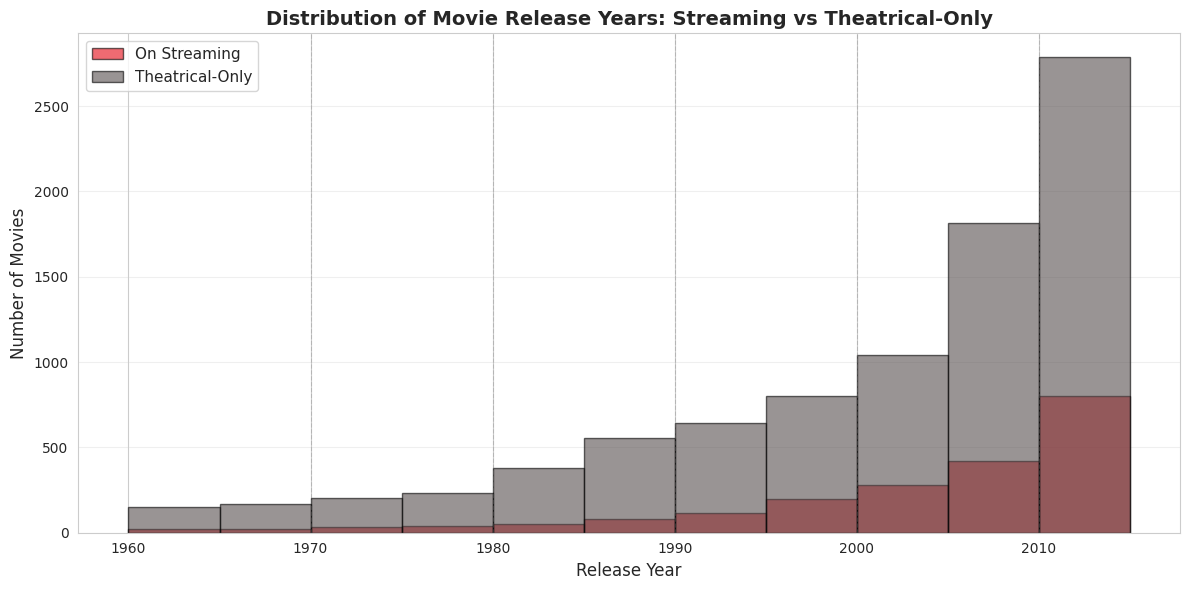

=== Release Year Statistics ===

Streaming movies:
  Median year: 2007
  Mean year: 2003.4
  Range: 1960-2015

Theatrical-only movies:
  Median year: 2005
  Mean year: 2000.8
  Range: 1960-2015

=== Movies by Decade ===
1960s:   43 streaming (  2.1%),  319 theatrical-only
1970s:   73 streaming (  3.5%),  434 theatrical-only
1980s:  131 streaming (  6.3%),  931 theatrical-only
1990s:  318 streaming ( 15.4%), 1446 theatrical-only
2000s:  696 streaming ( 33.7%), 2855 theatrical-only
2010-2015:  802 streaming ( 38.9%), 2787 theatrical-only


In [7]:
# Histogram of release years (streaming vs non-streaming)
fig, ax = plt.subplots(figsize=(12, 6))

# Create bins for decades; 5-year bins for better granularity
bins = np.arange(1960, 2020, 5)

# Plot streaming movies
streaming_years = xmdb_df[xmdb_df['on_streaming'] == True]['release_year']
ax.hist(streaming_years, bins=bins, alpha=0.6, label='On Streaming', 
        color='#E50914', edgecolor='black')

# Plot theatrical-only movies
theatrical_years = xmdb_df[xmdb_df['on_streaming'] == False]['release_year']
ax.hist(theatrical_years, bins=bins, alpha=0.6, label='Theatrical-Only',
        color='#564d4d', edgecolor='black')

# Formatting
ax.set_xlabel('Release Year', fontsize=12)
ax.set_ylabel('Number of Movies', fontsize=12)
ax.set_title('Distribution of Movie Release Years: Streaming vs Theatrical-Only', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add decade markers
for year in range(1970, 2020, 10):
    ax.axvline(year, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)

plt.tight_layout()
plt.show()

# Summary statistics
print("=== Release Year Statistics ===")
print(f"\nStreaming movies:")
print(f"  Median year: {streaming_years.median():.0f}")
print(f"  Mean year: {streaming_years.mean():.1f}")
print(f"  Range: {streaming_years.min():.0f}-{streaming_years.max():.0f}")

print(f"\nTheatrical-only movies:")
print(f"  Median year: {theatrical_years.median():.0f}")
print(f"  Mean year: {theatrical_years.mean():.1f}")
print(f"  Range: {theatrical_years.min():.0f}-{theatrical_years.max():.0f}")

# Decade breakdown
print("\n=== Movies by Decade ===")
decades = [(1960, 1969), (1970, 1979), (1980, 1989), (1990, 1999), 
           (2000, 2009), (2010, 2015)]

for start, end in decades:
    decade_label = f"{start}s" if end != 2015 else "2010-2015"
    streaming_count = ((streaming_years >= start) & (streaming_years <= end)).sum()
    theatrical_count = ((theatrical_years >= start) & (theatrical_years <= end)).sum()
    streaming_pct = streaming_count / len(streaming_years) * 100
    
    print(f"{decade_label}: {streaming_count:4d} streaming ({streaming_pct:5.1f}%), "
          f"{theatrical_count:4d} theatrical-only")

---

**Observations:** The histogram reveals a dramatic recency bias in streaming platform curation.

**Key Findings:**

1. Recent dominance: Over 72% of streaming movies come from the 2000s and 2010s (696 + 802 = 1,498 out of 2,063 movies). The 2010-2015 period alone accounts for 38.9% of all streaming content in our dataset.
2. The streaming surge: The visual clearly shows streaming (red) becoming increasingly prominent in recent decades. In the 2010-2015 bin, approximately 22% of all theatrical releases made it to streaming, compared to only ~12% in the 1960s-1980s.
3. Classic films ignored: Pre-1990 films represent only 11.9% of streaming catalogs (43 + 73 + 131 = 247 movies), despite making up 1,684 theatrical releases in our dataset. This suggests streaming platforms either:
    - Face higher licensing costs for classic films
    - Assume audiences prefer contemporary content
    - Encounter rights/quality issues with older titles
4. Statistical comparison: While the median years differ by only 2 years (2007 vs 2005), this masks the distribution shape. Streaming movies are heavily right-skewed toward recent releases, while theatrical-only films are more evenly distributed across decades (note the much larger gray bars in earlier periods).
5. The 1990s inflection point: The 1990s show the first substantial streaming presence (15.4% of streaming movies), suggesting this decade may represent a "sweet spot" of:
    - Modern enough for quality expectations
    - Old enough for affordable licensing
    - Culturally relevant for nostalgic viewing
  
 **Conclusion:** Streaming platforms overwhelmingly favor films from the past 15 years, with nearly 4 in 10 streaming movies released between 2010-2015. Classic cinema (pre-1990) is dramatically underrepresented, accounting for just 12% of streaming offerings despite being a third of theatrical releases in our dataset.

>**Question 2:** How do streaming platform catalogs compare in size and focus?
>
>**Hypothesis:** Amazon Prime likely has the largest catalog (it appeared to from our preliminary stats), while Disney+ may be the most selective.

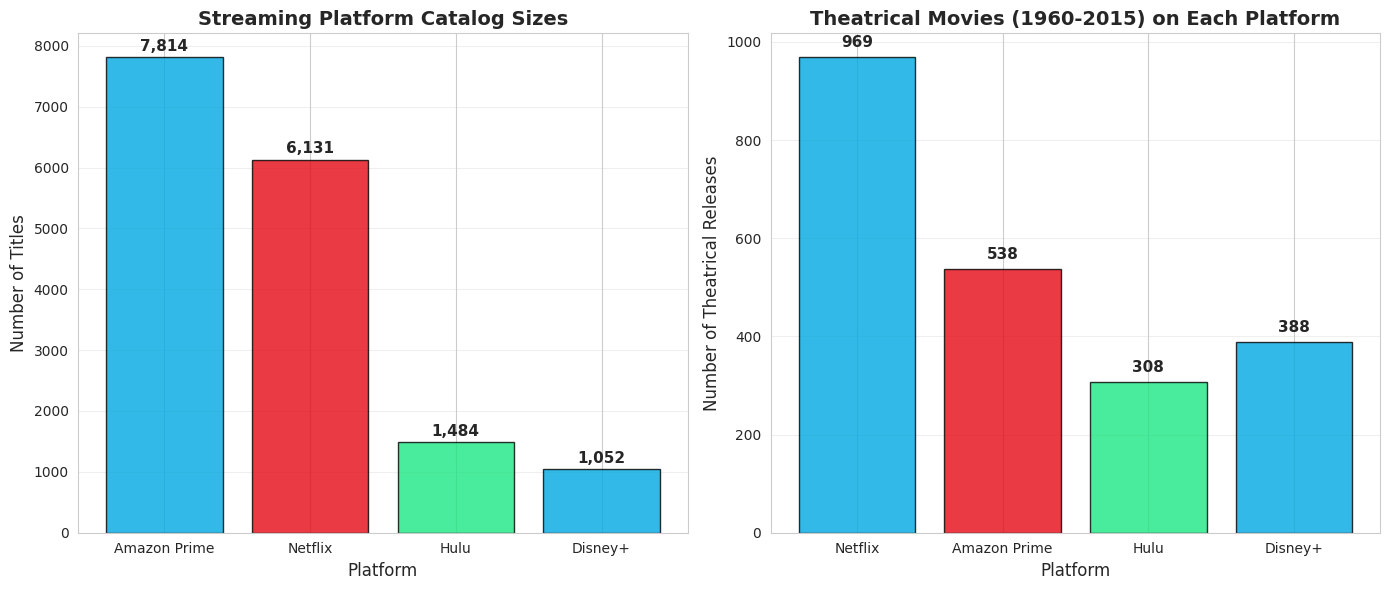

=== Platform Analysis ===

Amazon Prime:
  Total catalog: 7,814 titles
  Theatrical releases (1960-2015): 538 (6.9%)
  Likely originals/newer: 7,276

Netflix:
  Total catalog: 6,131 titles
  Theatrical releases (1960-2015): 969 (15.8%)
  Likely originals/newer: 5,162

Hulu:
  Total catalog: 1,484 titles
  Theatrical releases (1960-2015): 308 (20.8%)
  Likely originals/newer: 1,176

Disney+:
  Total catalog: 1,052 titles
  Theatrical releases (1960-2015): 388 (36.9%)
  Likely originals/newer: 664


In [8]:
# Count plot of platform distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Platform distribution (raw counts)
platform_counts = streaming_df['platform'].value_counts()

# Amazon, Netflix, Hulu, Disney colors
colors = ['#00A8E1', '#E50914', '#1CE783', '#00A8E1']

ax1.bar(platform_counts.index, platform_counts.values, color=colors, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Number of Titles', fontsize=12)
ax1.set_title('Streaming Platform Catalog Sizes', fontsize=14, fontweight='bold')
ax1.set_xlabel('Platform', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (platform, count) in enumerate(platform_counts.items()):
    ax1.text(i, count + 100, f'{count:,}', ha='center', fontsize=11, fontweight='bold')

# Right plot: Theatrical movies found on each platform
theatrical_on_platforms = {
    'Netflix': xmdb_df['on_netflix'].sum(),
    'Amazon Prime': xmdb_df['on_amazon'].sum(),
    'Hulu': xmdb_df['on_hulu'].sum(),
    'Disney+': xmdb_df['on_disney'].sum()
}

ax2.bar(theatrical_on_platforms.keys(), theatrical_on_platforms.values(), color=colors, edgecolor='black', alpha=0.8)
ax2.set_ylabel('Number of Theatrical Releases', fontsize=12)
ax2.set_title('Theatrical Movies (1960-2015) on Each Platform', fontsize=14, fontweight='bold')
ax2.set_xlabel('Platform', fontsize=12)
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, (platform, count) in enumerate(theatrical_on_platforms.items()):
    ax2.text(i, count + 20, f'{count:,}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate theatrical conversion rates
print("=== Platform Analysis ===")
for platform, total_count in platform_counts.items():
    theatrical_count = theatrical_on_platforms[platform]
    theatrical_pct = (theatrical_count / total_count) * 100
    
    print(f"\n{platform}:")
    print(f"  Total catalog: {total_count:,} titles")
    print(f"  Theatrical releases (1960-2015): {theatrical_count:,} ({theatrical_pct:.1f}%)")
    print(f"  Likely originals/newer: {total_count - theatrical_count:,}")

---

**Observations:** The dual visualization reveals that catalog size tells only half the story—what matters is what type of content fills those catalogs.

**Key Findings:**

1. Size vs. Focus disconnect: Amazon Prime has the largest catalog (7,814 titles) but the lowest theatrical focus (only 6.9% are 1960-2015 theatrical releases). In contrast, Disney+ has the smallest catalog (1,052 titles) but the highest theatrical focus (36.9% theatrical movies).
2. Three distinct strategies emerge:
    - **The Aggregator (Amazon Prime)**: Massive catalog, minimal theatrical curation. Only 538 of 7,814 titles are classic theatrical releases, suggesting heavy reliance on direct-to-streaming content, indie films, and international titles.
    - **The Balanced Platforms (Netflix & Hulu)**: Netflix leads in absolute theatrical count (969 movies, 15.8% of catalog), while Hulu shows stronger theatrical focus (20.8%) despite having fewer total titles. Both blend licensed theatrical content with originals.
    - **The Legacy Curator (Disney+)**: Smallest catalog but highest theatrical percentage (36.9%). Nearly 4 in 10 titles are theatrical releases, reflecting Disney's strategy of leveraging their historic studio library (Disney, Pixar, Marvel, Star Wars, Fox).
3. Netflix dominates theatrical licensing: Despite having 900 fewer titles than Amazon Prime, Netflix has licensed 431 more theatrical releases (969 vs 538), demonstrating more aggressive pursuit of classic film libraries.
4. Platforms prioritize exclusive content creation over theatrical licensing, with Disney+ being the exception due to their existing IP vault. Estimated original/newer content by platform:
    - Amazon Prime: ~7,276 titles (93% of catalog)
    - Netflix: ~5,162 titles (84% of catalog)
    - Hulu: ~1,176 titles (79% of catalog)
    - Disney+: ~664 titles (63% of catalog)
  
 **Conclusion:** Platform size doesn't equal theatrical focus. Disney+ pursues a "quality over quantity" approach with deep theatrical roots, while Amazon Prime opts for breadth over curated classic cinema. Netflix splits the difference, maintaining both the largest theatrical collection and substantial original programming.

> Multi-platform distribution analysis to see how many movies appear on multiple services. This will reveal whether platforms compete for exclusive theatrical licenses or share content liberally.

In [9]:
# Quick analysis: How many platforms is each movie on?
print("=== Multi-Platform Distribution ===")
platform_count_dist = xmdb_df[xmdb_df['on_streaming'] == True]['streaming_platforms'].value_counts().sort_index()

for count, movies in platform_count_dist.items():
    pct = movies / xmdb_df['on_streaming'].sum() * 100
    print(f"On {count} platform(s): {movies:,} movies ({pct:.1f}%)")

# Most promiscuous movies
multi_platform = xmdb_df[xmdb_df['streaming_platforms'] >= 2].sort_values('streaming_platforms', ascending=False)

print(f"\nMovies on most platforms (top 5):")
display(multi_platform[
        ['original_title', 'release_year', 'streaming_platforms', 'on_netflix', 'on_hulu', 'on_disney', 'on_amazon']
    ].head()
)

=== Multi-Platform Distribution ===
On 1 platform(s): 1,929 movies (93.5%)
On 2 platform(s): 128 movies (6.2%)
On 3 platform(s): 6 movies (0.3%)

Movies on most platforms (top 5):


,original_title,release_year,streaming_platforms,on_netflix,on_hulu,on_disney,on_amazon
209,The Vatican Tapes,2015,3,True,True,False,True
3372,The Girl with the Dragon Tattoo,2011,3,True,True,False,True
1046,Zapped,2014,3,True,True,True,False
364,The Girl King,2015,3,True,True,False,True
2910,21,2008,3,True,True,False,True


---

**Observations:** The multi-platform analysis reveals that streaming is a zero-sum game for theatrical releases—platforms rarely share content.

**Key Findings:**

1. Overwhelming exclusivity: A staggering 93.5% of streaming movies appear on only one platform (1,929 out of 2,063). This demonstrates aggressive exclusive licensing strategies where platforms compete rather than coexist.
2. Rare sharing: Only 6.2% of movies appear on two platforms (128 movies), and multi-platform availability drops to near zero at three platforms (just 6 movies, or 0.3%). No theatrical release in our dataset appears on all four platforms.
3. The Disney moat: Four of the most widely-available movies (appearing on 3 platforms) are on Netflix + Hulu + Amazon, but not Disney+. This reflects Disney's vertical integration strategy—they don't normally license their owned content to competitors, while other platforms must compete for non-Disney titles.
4. These are mid-tier theatrical releases without strong studio allegiances, suggesting independent films or non-exclusive studio deals are the only content that crosses platform boundaries. The only movies on 3 platforms include:
    - *The Vatican Tapes* (2015)
    - *The Girl with the Dragon Tattoo* (2011)
    - *Zapped* (2014)
    - *The Girl King* (2015)
    - *21* (2008)
5. Licensing calculus: With 2,063 streaming movies spread across 4 platforms, if content were shared randomly, we'd expect ~25% overlap. Instead, we see 6.5% overlap, indicating platforms pay premiums for exclusivity to differentiate catalogs and reduce churn.

 **Conclusion:** Streaming platforms treat theatrical releases as competitive assets, not shared resources. The near-total exclusivity (93.5% single-platform) reveals an industry where content licensing is a strategic weapon in subscriber acquisition wars. Disney+ operates as a nearly closed ecosystem, while Netflix, Hulu, and Amazon occasionally compete for the same titles, with only 6 movies managing to appear across all three.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The primary variables explored were release year and platform availability. The release year distribution for streaming movies showed a strong right skew toward recent releases, with the 2010-2015 period alone accounting for 38.9% of all streaming content. No transformations were needed as the temporal pattern was clear in raw form.

Platform distribution revealed a power law—Amazon Prime dominates by volume (7,814 titles) but Netflix leads in theatrical curation (969 theatrical releases). The `streaming_platforms` variable showed an extreme concentration at 1 (93.5% exclusivity), indicating this is essentially a binary variable (exclusive vs. shared) rather than a continuous distribution.

No unusual outliers were detected in these distributions, though the extreme rarity of 3-platform movies (only 6 total) was noteworthy.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

No data transformations were required for the univariate exploration, as the datasets were pre-cleaned in the data wrangling phase (Project 2). The streaming availability flags (on_netflix, on_hulu, etc.) were already in clean boolean form, and release_year required no adjustment.

The most unusual distribution was the multi-platform availability—with 93.5% of movies on exactly one platform, this variable showed an extreme lack of spread. This wasn't a data quality issue but rather a revealing finding about industry licensing practices.

The `platform` variable in the streaming_df dataset showed uneven representation (Amazon: 47%, Netflix: 37%, Hulu: 9%, Disney+: 6%), but this reflects actual market catalog sizes rather than a data collection artifact.

## Bivariate Exploration

### Section Overview

In this section, I investigate relationships between pairs of variables to understand how streaming availability interacts with financial performance, ratings, and content characteristics. The univariate exploration revealed that streaming platforms favor recent releases and operate with near-total exclusivity. Now I'll examine whether movies that ended up on streaming differ systematically in their financial success, quality ratings, and genre composition.

I continue using the **Question-Visualization-Observations** framework to structure each investigation.

### Key Relationships to Explore

1. **Budget vs Revenue** (colored by streaming status) - Do streaming movies cluster differently in the budget-revenue space?
2. **ROI by Streaming Status** - Validating and explaining the surprising preliminary finding that streaming movies have higher median ROI
3. **Genre Distribution Across Platforms** - Which genres dominate which platforms' curation strategies?

>**Question 3:**  Do streaming and theatrical-only movies differ in their budget-revenue relationships?
>
>**Hypothesis:** Streaming platforms might license lower-budget films that underperformed theatrically, making them cheaper to acquire.

Movies with complete financial data: 3,854
  Streaming: 1,090
  Theatrical-only: 2,764


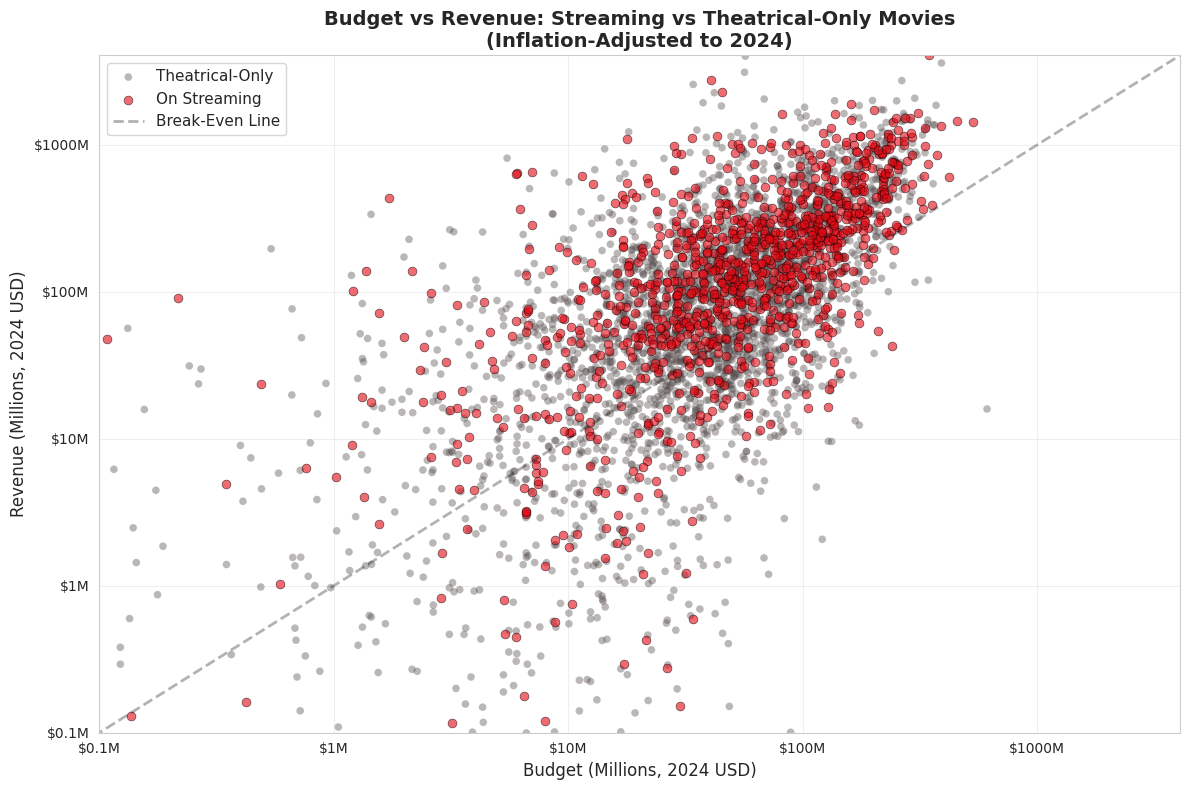


=== Budget Statistics (2024 USD) ===
Streaming movies:
  Median budget: $54.3M
  Mean budget: $78.0M

Theatrical-only movies:
  Median budget: $39.4M
  Mean budget: $58.0M

=== Revenue Statistics (2024 USD) ===
Streaming movies:
  Median revenue: $139.7M
  Mean revenue: $254.3M

Theatrical-only movies:
  Median revenue: $72.3M
  Mean revenue: $174.7M

=== Profitability (Revenue > Budget) ===
Streaming movies: 892/1090 profitable (81.8%)
Theatrical-only: 1886/2764 profitable (68.2%)


In [10]:
# Scatter plot - Budget vs Revenue (colored by streaming status)

# Filter to movies with complete financial data
financial_df = xmdb_df[xmdb_df['budget_adj_2024'].notna() & xmdb_df['revenue_adj_2024'].notna()].copy()

print(f"Movies with complete financial data: {len(financial_df):,}")
print(f"  Streaming: {financial_df['on_streaming'].sum():,}")
print(f"  Theatrical-only: {(~financial_df['on_streaming']).sum():,}")

# Create figure
fig, ax = plt.subplots(figsize=(12, 8))

# Plot theatrical-only (behind, so streaming shows on top)
theatrical = financial_df[~financial_df['on_streaming']]
ax.scatter(theatrical['budget_adj_2024'] / 1e6, 
           theatrical['revenue_adj_2024'] / 1e6,
           alpha=0.4, s=30, color='#564d4d', label='Theatrical-Only', 
           edgecolors='none')

# Plot streaming (on top)
streaming = financial_df[financial_df['on_streaming']]
ax.scatter(streaming['budget_adj_2024'] / 1e6,
           streaming['revenue_adj_2024'] / 1e6,
           alpha=0.6, s=40, color='#E50914', label='On Streaming',
           edgecolors='black', linewidths=0.5)

# Add break-even line
max_val = max(financial_df['budget_adj_2024'].max(), financial_df['revenue_adj_2024'].max()) / 1e6
ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=2, label='Break-Even Line')

# Formatting
ax.set_xlabel('Budget (Millions, 2024 USD)', fontsize=12)
ax.set_ylabel('Revenue (Millions, 2024 USD)', fontsize=12)
ax.set_title('Budget vs Revenue: Streaming vs Theatrical-Only Movies\n(Inflation-Adjusted to 2024)', 
             fontsize=14, fontweight='bold')

ax.legend(fontsize=11, loc='upper left')
ax.grid(alpha=0.3)

# Log scale for better visibility (optional - comment out if linear looks better)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, max_val)
ax.set_ylim(0.1, max_val)

ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== Budget Statistics (2024 USD) ===")
print(f"Streaming movies:")
print(f"  Median budget: ${streaming['budget_adj_2024'].median()/1e6:.1f}M")
print(f"  Mean budget: ${streaming['budget_adj_2024'].mean()/1e6:.1f}M")

print(f"\nTheatrical-only movies:")
print(f"  Median budget: ${theatrical['budget_adj_2024'].median()/1e6:.1f}M")
print(f"  Mean budget: ${theatrical['budget_adj_2024'].mean()/1e6:.1f}M")

print("\n=== Revenue Statistics (2024 USD) ===")
print(f"Streaming movies:")
print(f"  Median revenue: ${streaming['revenue_adj_2024'].median()/1e6:.1f}M")
print(f"  Mean revenue: ${streaming['revenue_adj_2024'].mean()/1e6:.1f}M")

print(f"\nTheatrical-only movies:")
print(f"  Median revenue: ${theatrical['revenue_adj_2024'].median()/1e6:.1f}M")
print(f"  Mean revenue: ${theatrical['revenue_adj_2024'].mean()/1e6:.1f}M")

# Success rates (above break-even)
streaming_profitable = (streaming['revenue_adj_2024'] > streaming['budget_adj_2024']).sum()
theatrical_profitable = (theatrical['revenue_adj_2024'] > theatrical['budget_adj_2024']).sum()

print("\n=== Profitability (Revenue > Budget) ===")
print(f"Streaming movies: {streaming_profitable}/{len(streaming)} profitable ({streaming_profitable/len(streaming)*100:.1f}%)")
print(f"Theatrical-only: {theatrical_profitable}/{len(theatrical)} profitable ({theatrical_profitable/len(theatrical)*100:.1f}%)")

---

**Observations:** The scatter plot reveals a surprising pattern: streaming platforms preferentially license higher-budget, higher-performing theatrical releases, not bargain-bin content.

**Key Findings:**

1. Streaming movies are **MORE expensive**. The median streaming movie cost \\$54.3M to produce (inflation-adjusted), compared to \\$39.4M for theatrical-only releases - a 38% premium. This directly contradicts the assumption that streaming platforms license cheap content.
2. Streaming movies **earn MORE**. Median revenue for streaming movies is \\$139.7M vs \\$72.3M for theatrical-only - a 93% difference. Streaming platforms aren't acquiring underperformers; they're licensing blockbusters.
3. Streaming movies are **MORE profitable**. A staggering 81.8% of streaming movies exceeded their budgets, compared to only 68.2% of theatrical-only releases. This 13.6-percentage-point gap explains the ROI surprise from preliminary analysis — streaming platforms systematically avoid flops.
4. Red dots (streaming) concentrate heavily in the \\$20M-\\$200M budget range and cluster above the break-even line, particularly in the "successful mid-budget" zone (\\$30M-\\$100M budget,\\$50M-\\$300M revenue). Gray dots (theatrical-only) spread more evenly across the entire financial spectrum, including many below-break-even failures.
5. Very few streaming movies appear in the ultra-low-budget zone (<\\$5M). The gray dots dominate this space, suggesting streaming platforms avoid micro-budget indies despite their potentially high ROI percentages.

Streaming platforms likely:

- License proven successes to attract subscribers with recognizable titles
- Avoid acquisition risk by targeting movies that already demonstrated theatrical appeal
- Pay premiums for mid-budget hits (\\$30M-\\$100M) that balance brand recognition with licensing costs
- Skip ultra-low-budget content that lacks production value for streaming quality expectations

 **Conclusion:** Streaming platforms don't license "failures" - they license winners. The higher median budget (+\\$15M), higher revenue (+\\$67M), and higher profitability rate (+13.6 points) demonstrate a curation strategy focused on acquiring commercially successful theatrical releases, not rescuing underperformers.

>**Question 4:** How do ROI distributions compare between streaming and theatrical-only releases?
>
>**Hypothesis:** The higher median ROI for streaming movies might be explained by tighter risk management - fewer extreme losers.

Movies with ROI data: 3,854
  Streaming: 1,090
  Theatrical-only: 2,764


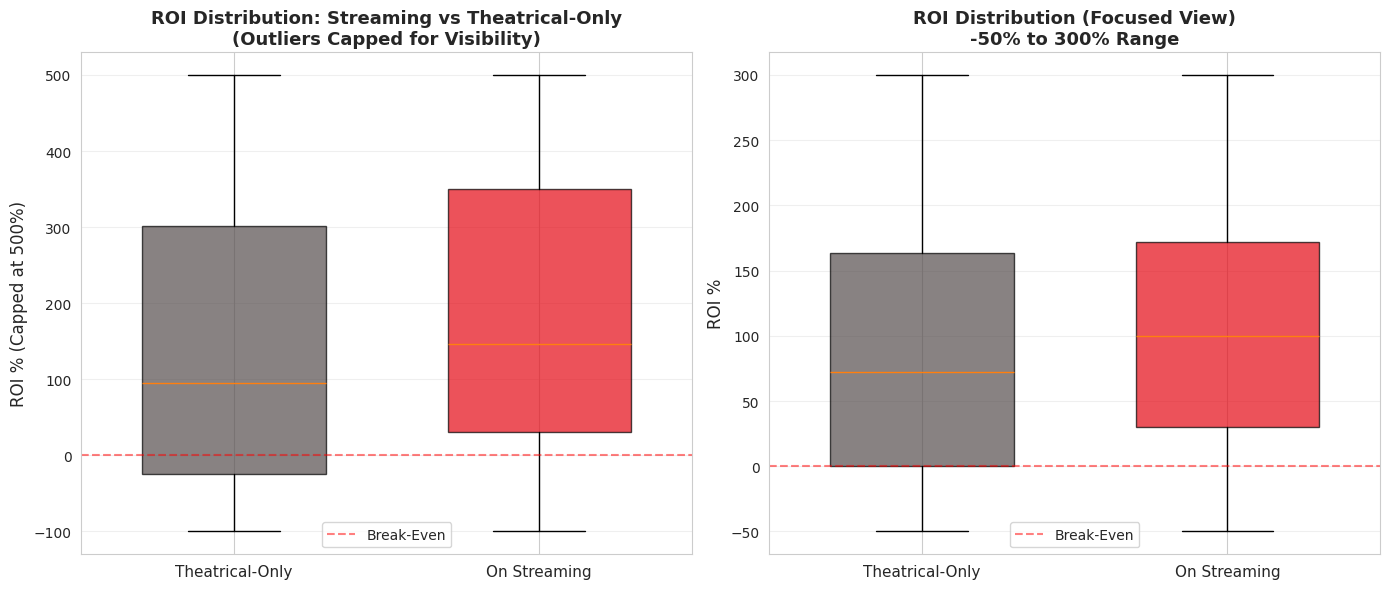


=== ROI Statistics (Full Data) ===
Streaming movies:
  Median ROI: 145.9%
  Mean ROI: 97567.2%
  25th percentile: 30.5%
  75th percentile: 349.5%

Theatrical-only movies:
  Median ROI: 94.9%
  Mean ROI: 2941.8%
  25th percentile: -24.2%
  75th percentile: 301.6%

=== Loss Rates (ROI < 0%) ===
Streaming: 198/1090 movies lost money (18.2%)
Theatrical-only: 874/2764 movies lost money (31.6%)


In [11]:
# Box plot - ROI by streaming status

# Filter to movies with ROI data
roi_df = xmdb_df[xmdb_df['roi'].notna()].copy()

print(f"Movies with ROI data: {len(roi_df):,}")
print(f"  Streaming: {roi_df['on_streaming'].sum():,}")
print(f"  Theatrical-only: {(~roi_df['on_streaming']).sum():,}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Full distribution (capped for visibility)
roi_capped = roi_df.copy()
roi_capped['roi_capped'] = roi_capped['roi'].clip(upper=500)  # Cap extreme outliers

streaming_roi = roi_capped[roi_capped['on_streaming']]['roi_capped']
theatrical_roi = roi_capped[~roi_capped['on_streaming']]['roi_capped']

box_data = [theatrical_roi, streaming_roi]
positions = [1, 2]
colors = ['#564d4d', '#E50914']

bp = ax1.boxplot(box_data, positions=positions, widths=0.6, patch_artist=True,
                  showfliers=True, flierprops=dict(marker='o', markersize=3, alpha=0.3))

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('ROI % (Capped at 500%)', fontsize=12)

ax1.set_title('ROI Distribution: Streaming vs Theatrical-Only\n(Outliers Capped for Visibility)', 
              fontsize=13, fontweight='bold')

ax1.set_xticklabels(['Theatrical-Only', 'On Streaming'], fontsize=11)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Break-Even')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Right plot: Focus on central tendency (more extreme cap)
roi_focused = roi_df.copy()
roi_focused = roi_focused[roi_focused['roi'].between(-50, 300)]  # Focus on typical range

streaming_roi_focused = roi_focused[roi_focused['on_streaming']]['roi']
theatrical_roi_focused = roi_focused[~roi_focused['on_streaming']]['roi']

box_data_focused = [theatrical_roi_focused, streaming_roi_focused]

bp2 = ax2.boxplot(box_data_focused, positions=positions, widths=0.6, patch_artist=True, showfliers=False)

for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_ylabel('ROI %', fontsize=12)
ax2.set_title('ROI Distribution (Focused View)\n-50% to 300% Range', fontsize=13, fontweight='bold')
ax2.set_xticklabels(['Theatrical-Only', 'On Streaming'], fontsize=11)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Break-Even')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Detailed statistics
print("\n=== ROI Statistics (Full Data) ===")
print(f"Streaming movies:")
print(f"  Median ROI: {roi_df[roi_df['on_streaming']]['roi'].median():.1f}%")
print(f"  Mean ROI: {roi_df[roi_df['on_streaming']]['roi'].mean():.1f}%")
print(f"  25th percentile: {roi_df[roi_df['on_streaming']]['roi'].quantile(0.25):.1f}%")
print(f"  75th percentile: {roi_df[roi_df['on_streaming']]['roi'].quantile(0.75):.1f}%")

print(f"\nTheatrical-only movies:")
print(f"  Median ROI: {roi_df[~roi_df['on_streaming']]['roi'].median():.1f}%")
print(f"  Mean ROI: {roi_df[~roi_df['on_streaming']]['roi'].mean():.1f}%")
print(f"  25th percentile: {roi_df[~roi_df['on_streaming']]['roi'].quantile(0.25):.1f}%")
print(f"  75th percentile: {roi_df[~roi_df['on_streaming']]['roi'].quantile(0.75):.1f}%")

# Loss rates
streaming_losses = (roi_df[roi_df['on_streaming']]['roi'] < 0).sum()
theatrical_losses = (roi_df[~roi_df['on_streaming']]['roi'] < 0).sum()

print(f"\n=== Loss Rates (ROI < 0%) ===")
print(f"Streaming: {streaming_losses}/{roi_df['on_streaming'].sum()} movies lost money ({streaming_losses/roi_df['on_streaming'].sum()*100:.1f}%)")
print(f"Theatrical-only: {theatrical_losses}/{(~roi_df['on_streaming']).sum()} movies lost money ({theatrical_losses/(~roi_df['on_streaming']).sum()*100:.1f}%)")

---

**Observations:** The dual box plots confirm that streaming platforms don't just license more profitable movies - they license lower-risk movies with more predictable returns.

**Key Findings:**

1. Streaming movies achieve a median ROI of 145.9% vs 94.9% for theatrical-only - a 51-percentage-point gap. This validates our preliminary finding with complete distribution visibility.
2. The interquartile range (IQR) reveals streaming's risk aversion. More tellingly, streaming's 25th percentile is positive (30.5%), meaning 75% of streaming movies are profitable. For theatrical-only, the 25th percentile is -24.2%, meaning 25% of titles lost more than 24% of their budgets.
    - Streaming IQR: 30.5% to 349.5% (319-point spread)
    - Theatrical-only IQR: -24.2% to 301.6% (326-point spread)
3. Dramatically lower failure rate. Only 18.2% of streaming movies lost money (198 out of 1,090), compared to 31.6% of theatrical-only releases (874 out of 2,764). Streaming platforms have reduced downside risk by 42% (from 31.6% to 18.2%).
4. Similar upside potential. The 75th percentiles are nearly identical (349.5% vs 301.6%), indicating both groups can achieve blockbuster-level returns. The difference is streaming platforms avoid the losers (left side of distribution) while maintaining access to winners (right side).
5. Extreme outliers exist in both groups. The mean ROIs (97,567% streaming, 2,941% theatrical) are distorted by rare mega-hits like low-budget horror films that earned 100x+ their budgets. However, these outliers don't change the fundamental pattern: streaming = safer bets.

The focused view (right panel) shows the critical difference clearly:
- Streaming's box sits entirely above 0%, with the median near 100%
- Theatrical-only's box straddles the break-even line, with substantial mass below 0%
- Streaming's distribution is shifted upward and compressed, indicating consistent moderate success over risky boom-or-bust outcomes

Streaming platforms pay licensing fees based on past performance, so they can cherry-pick winners using hindsight. A theatrical studio must greenlight projects with uncertainty; a streaming platform licenses with complete box office data in hand. This information asymmetry allows streaming services to:
- Avoid known flops (31.6% to 18.2% loss rate)
- Target proven successes (median ROI: 95% to 146%)
- Minimize variance (25th percentile: -24% to +31%)

 **Conclusion:** Streaming platforms operate as cinematic insurance actuaries, selecting movies with demonstrated profitability and avoiding theatrical failures. The 51% median ROI advantage and 42% reduction in failure rate prove this isn't random sampling, but strategic curation.

>**Question 5:** Do streaming platforms specialize in different genres, or do they all curate similar content?
>
>**Hypothesis:** Disney+ likely specializes in family-friendly content due to their brand, while other platforms might be more generalist.

Analyzing 2,063 streaming movies


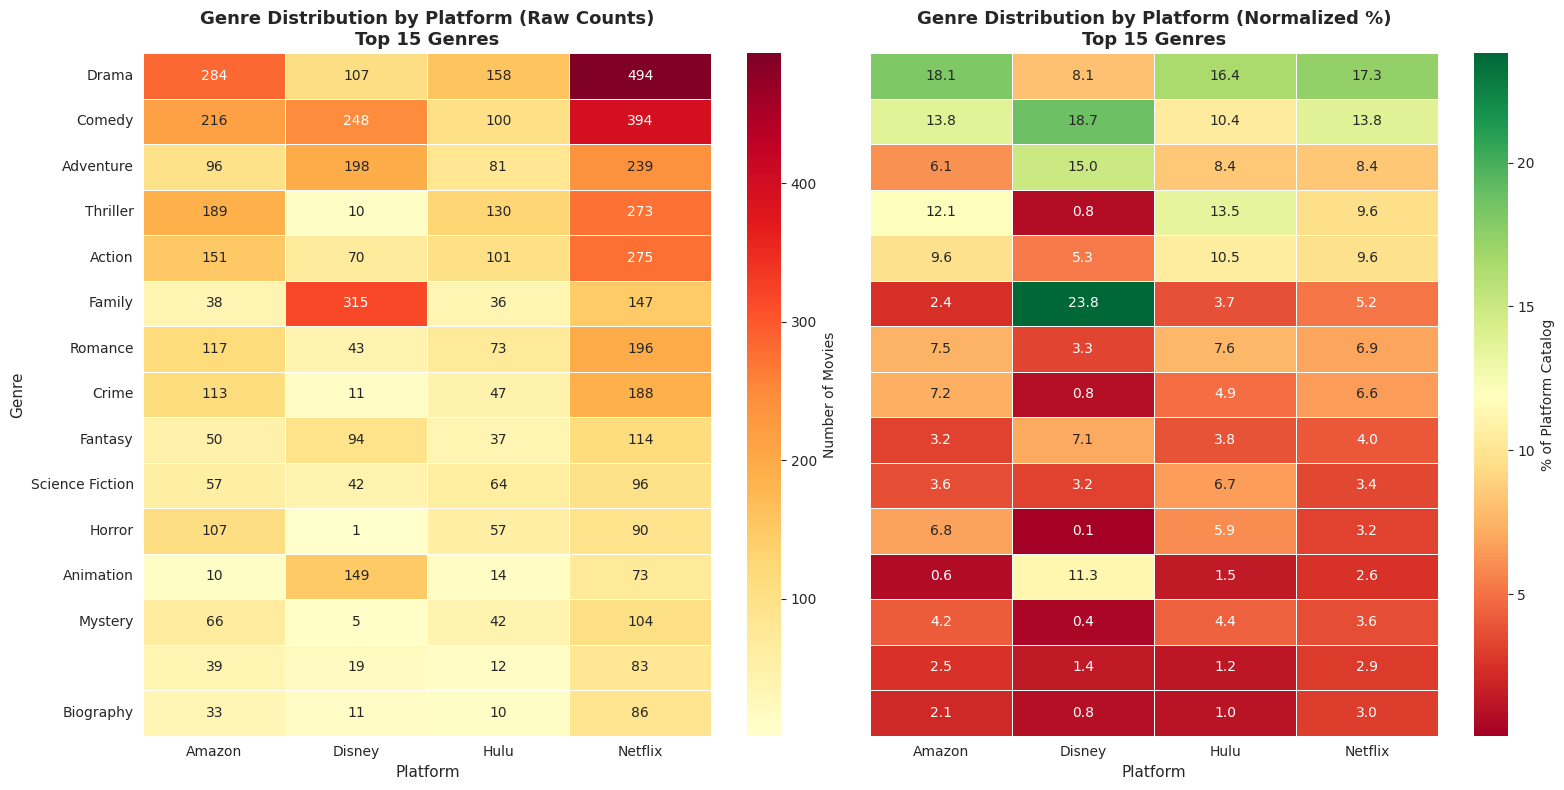


=== Top 3 Genres per Platform (by %) ===

Amazon:
  Drama: 18.1% (284 movies)
  Comedy: 13.8% (216 movies)
  Thriller: 12.1% (189 movies)

Disney:
  Family: 23.8% (315 movies)
  Comedy: 18.7% (248 movies)
  Adventure: 15.0% (198 movies)

Hulu:
  Drama: 16.4% (158 movies)
  Thriller: 13.5% (130 movies)
  Action: 10.5% (101 movies)

Netflix:
  Drama: 17.3% (494 movies)
  Comedy: 13.8% (394 movies)
  Action: 9.6% (275 movies)

=== Platform Dominance by Genre ===
(Which platform has the most movies in each top genre)
Drama               : Netflix         (494/1043 = 47.4%)
Comedy              : Netflix         (394/958 = 41.1%)
Adventure           : Netflix         (239/614 = 38.9%)
Thriller            : Netflix         (273/602 = 45.3%)
Action              : Netflix         (275/597 = 46.1%)
Family              : Disney          (315/536 = 58.8%)
Romance             : Netflix         (196/429 = 45.7%)
Crime               : Netflix         (188/359 = 52.4%)
Fantasy             : Netflix  

In [12]:
# Heatmap - Genre × Platform

# First, we need to explode genres and analyze by platform
# Get streaming movies only
streaming_movies = xmdb_df[xmdb_df['on_streaming'] == True].copy()

print(f"Analyzing {len(streaming_movies):,} streaming movies")

# Create platform-genre counts
genre_platform_data = []

for platform in ['on_netflix', 'on_hulu', 'on_disney', 'on_amazon']:
    platform_name = platform.replace('on_', '').replace('_', ' ').title()
    platform_movies = streaming_movies[streaming_movies[platform] == True]
    
    # Split genres and count
    all_genres = []
    for genres_str in platform_movies['genres'].dropna():
        if isinstance(genres_str, str):
            all_genres.extend([g.strip().replace("'", "").replace('(', '').replace(')', '') for g in genres_str.split(',')])
    
    genre_counts = pd.Series(all_genres).value_counts()
    
    for genre, count in genre_counts.items():
        genre_platform_data.append({
            'Platform': platform_name,
            'Genre': genre,
            'Count': count
        })
        
# Create DataFrame
gp_df = pd.DataFrame(genre_platform_data)

# Pivot for heatmap
heatmap_data = gp_df.pivot(index='Genre', columns='Platform', values='Count').fillna(0)

# Sort by total count to show most common genres at top
heatmap_data['Total'] = heatmap_data.sum(axis=1)
heatmap_data = heatmap_data.sort_values('Total', ascending=False).drop('Total', axis=1)

# Take top 15 genres for readability
heatmap_data = heatmap_data.head(15)

# Create normalized version (percentage of each platform's catalog)
platform_totals = heatmap_data.sum(axis=0)
heatmap_pct = heatmap_data.div(platform_totals) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left: Raw counts
sb.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Number of Movies'}, ax=ax1, linewidths=0.5)
ax1.set_title('Genre Distribution by Platform (Raw Counts)\nTop 15 Genres', fontsize=13, fontweight='bold')
ax1.set_xlabel('Platform', fontsize=11)
ax1.set_ylabel('Genre', fontsize=11)

# Right: Percentages (better for comparison)
sb.heatmap(heatmap_pct, annot=True, fmt='.1f', cmap='RdYlGn', 
            cbar_kws={'label': '% of Platform Catalog'}, ax=ax2, linewidths=0.5)

ax2.set_title('Genre Distribution by Platform (Normalized %)\nTop 15 Genres', fontsize=13, fontweight='bold')
ax2.set_xlabel('Platform', fontsize=11)
ax2.set_ylabel('', fontsize=11)
ax2.set_yticklabels([])  # Remove duplicate labels

plt.tight_layout()
plt.show()

# Platform specialization analysis
print("\n=== Top 3 Genres per Platform (by %) ===")
for platform in heatmap_pct.columns:
    top_genres = heatmap_pct[platform].nlargest(3)
    print(f"\n{platform}:")
    
    for genre, pct in top_genres.items():
        count = heatmap_data.loc[genre, platform]
        print(f"  {genre}: {pct:.1f}% ({count:.0f} movies)")

# Genre dominance - which platform has most of each genre?
print("\n=== Platform Dominance by Genre ===")
print("(Which platform has the most movies in each top genre)")

for genre in heatmap_data.head(10).index:
    dominant_platform = heatmap_data.loc[genre].idxmax()
    count = heatmap_data.loc[genre, dominant_platform]
    total = heatmap_data.loc[genre].sum()
    pct = count / total * 100
    
    print(f"{genre:20s}: {dominant_platform:15s} ({count:.0f}/{total:.0f} = {pct:.1f}%)")

---

**Observations:** The dual heatmap reveals that while Drama remains prominent across all platforms, each service cultivates a distinct genre identity that reflects their brand positioning and competitive strategy.

**Key Findings:**

1. Disney+ is the family powerhouse. Disney+ dedicates 23.8% of its catalog to Family content (315 movies) - nearly 10x higher than competitors (Amazon 2.4%, Netflix 5.2%, Hulu 3.7%). Combined with Adventure (15.0%) and Comedy (18.7%), Disney maintains a family-friendly brand that differentiates it completely from competitors. Disney also captures 58.8% of all streaming Family movies, demonstrating near-monopoly control of this genre.
2. Netflix's strategy is clear: own the largest slice of every genre to become the default streaming service. Their percentages are balanced (Drama 17.3%, Comedy 13.8%, Action 9.6%), but absolute counts dwarf competitors. Netflix dominates by raw volume in every single genre, owning:
    - 47.4% of all Drama (494 movies)
    - 52.4% of all Crime (188 movies)
    - 45.7% of all Romance (196 movies)
    - 45.3% of all Thriller (273 movies)
    - 46.1% of all Action (275 movies)
3. Amazon emphasizes Drama and Thriller. Amazon dedicates 18.1% to Drama (284 movies) and 12.1% to Thriller (189 movies), positioning itself as a drama-focused platform. However, their lower absolute counts compared to Netflix (284 vs 494 dramas) reveal they're still building catalog depth.
4. Hulu carves the thriller/action niche. Hulu shows the strongest focus on Thriller (13.5%) and Action (10.5%), suggesting positioning as the "edgy adult" alternative. Combined with lower Family content (3.7%), Hulu differentiates from Disney+ despite being under the same corporate umbrella.
5. Every platform's top genre is Drama (16.4%-18.1% of catalogs), but platforms differentiate through their \#2 and \#3 genres:
    - Disney+: Family (23.8%), Comedy (18.7%), Adventure (15.0%)
    - Netflix: Drama (17.3%), Comedy (13.8%), Action (9.6%)
    - Hulu: Drama (16.4%), Thriller (13.5%), Action (10.5%)
    - Amazon: Drama (18.1%), Comedy (13.8%), Thriller (12.1%)
6. Disney's 315 Family movies vs Netflix's 147 (despite Netflix having 4x more total theatrical releases) proves Disney actively withholds its owned family content from licensing. The 58.8% Disney market share in Family is defensive vertical integration - competitors literally cannot compete for Disney/Pixar/Marvel content.

The normalized heatmap (right panel) reveals distinct color signatures:

- Disney+ column: Deep green at Family (23.8%), unique among all platforms
- Netflix column: Consistent orange-yellow (13-17%) showing balanced diversification
- Hulu column: Red-orange throughout, reflecting smaller focused catalog
- Amazon column: Similar to Netflix but slightly more Drama-heavy

**Platform Strategies**:

- Disney+: Vertical integration fortress - leverage owned IP for unassailable family content dominance (23.8% vs ~3% competitors)
- Netflix: Horizontal monopolization - capture 40-50% of every genre through aggressive licensing (\\$17B+ annual content budget)
- Hulu: Complementary niche—focus on thriller/action to avoid cannibalizing Disney+ family subscribers
- Amazon: Me-too follower - mimic Netflix's genre mix but at lower scale, relying on Prime membership bundling rather than content differentiation

 **Conclusion:** Streaming platforms are not interchangeable. Disney+ operates as a family-content monopolist (58.8% genre market share), Netflix positions as the volume leader across all genres (40-52% shares in most categories), and Hulu carves an adult thriller/action niche. Genre curation is a core competitive weapon, not a byproduct of random licensing.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Streaming availability showed strong relationships with financial performance, risk profiles, and genre composition:

1. **Budget-Revenue relationship**: Streaming movies cluster in the \\$30M-\\$100M budget range with consistently higher revenues (median \\$139.7M vs \\$72.3M). The scatter plot revealed streaming platforms license expensive winners, not cheap failures - streaming movies have 38% higher budgets and 93% higher revenues than theatrical-only releases.
2. **ROI advantage with risk reduction**: Streaming movies achieve a 51-percentage-point higher median ROI (145.9% vs 94.9%) and 42% lower failure rate (18.2% vs 31.6% loss rate). The box plots showed streaming platforms systematically avoid losers while maintaining access to blockbuster upside—their 25th percentile ROI is +30.5% (profitable) vs theatrical-only's -24.2% (loss).
3. **Genre specialization by platform**: The heatmap revealed distinct platform personalities. Disney+ dedicates 23.8% to Family content (capturing 58.8% of all streaming family movies), Netflix dominates by volume across all genres (40-52% market shares), and Hulu carves a thriller/action niche (13.5% thriller, highest percentage). Drama is universal (#1 on all platforms at 16-18%), but secondary genres reveal competitive positioning.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

Beyond streaming availability, several secondary patterns emerged:

1. Platform size does not equal theatrical focus. Amazon Prime has the largest catalog (7,814 titles) but lowest theatrical percentage (6.9%), while Disney+ has the smallest catalog (1,052) but highest theatrical focus (36.9%). This inverse relationship suggests platforms prioritize either breadth (Amazon's originals strategy) or depth (Disney's library strategy).
2. Genre volume creates monopoly. Netflix's dominance across genres (owning 45-52% of Crime, Drama, Romance, Thriller, and Action) creates a self-reinforcing cycle - more content attracts more subscribers, funding more licensing. Other platforms can only compete through specialization (Disney's 58.8% Family monopoly, Hulu's thriller focus).
3. The budget-revenue scatter plot revealed that streaming acquisitions concentrate in \\$30M-\\$100M budgets, avoiding both ultra-low-budget (<\\$5M) and mega-blockbusters (>\\$200M). This sweet spot balances production value (appealing to subscribers) with licensing costs (affordable at scale).
4. Profitability determines licensing: The 81.8% profit rate for streaming movies vs 68.2% for theatrical-only proves platforms use hindsight advantage - they license with complete box office data, cherry-picking winners and avoiding known flops. Studios must greenlight blindly; streaming platforms license with perfect information.

## Multivariate Exploration

### Section Overview

In this section, I investigate relationships among three or more variables to uncover deeper patterns that emerge when combining temporal, financial, and categorical dimensions. The univariate and bivariate explorations revealed that streaming platforms favor recent releases, license higher-budget winners, and specialize by genre. Now I'll examine how these patterns interact - does the budget-revenue relationship differ by decade? How have platform genre preferences evolved over time?

I continue using the **Question-Visualization-Observations** framework, with attention to encoding choices that avoid overplotting and clearly communicate multi-dimensional patterns.

### Key Relationships to Explore

1. **Budget vs Revenue faceted by Decade** (colored by streaming status) - Has streaming's financial profile changed over time?
2. **Scatterplot with multiple encodings: ROI vs Rating** (color, size, and facets) - What combinations predict streaming acquisition?

>**Question 6:** How have streaming acquisition patterns evolved across decades?
>
>**Hypothesis:** Streaming platforms likely focus on the most recent releases, but we need to understand if their financial selectivity (higher budgets, higher ROI) holds across all time periods or only recent decades.

Analyzing 3,650 movies from 1980-2015
Decades: [1980, 1990, 2000, 2010]


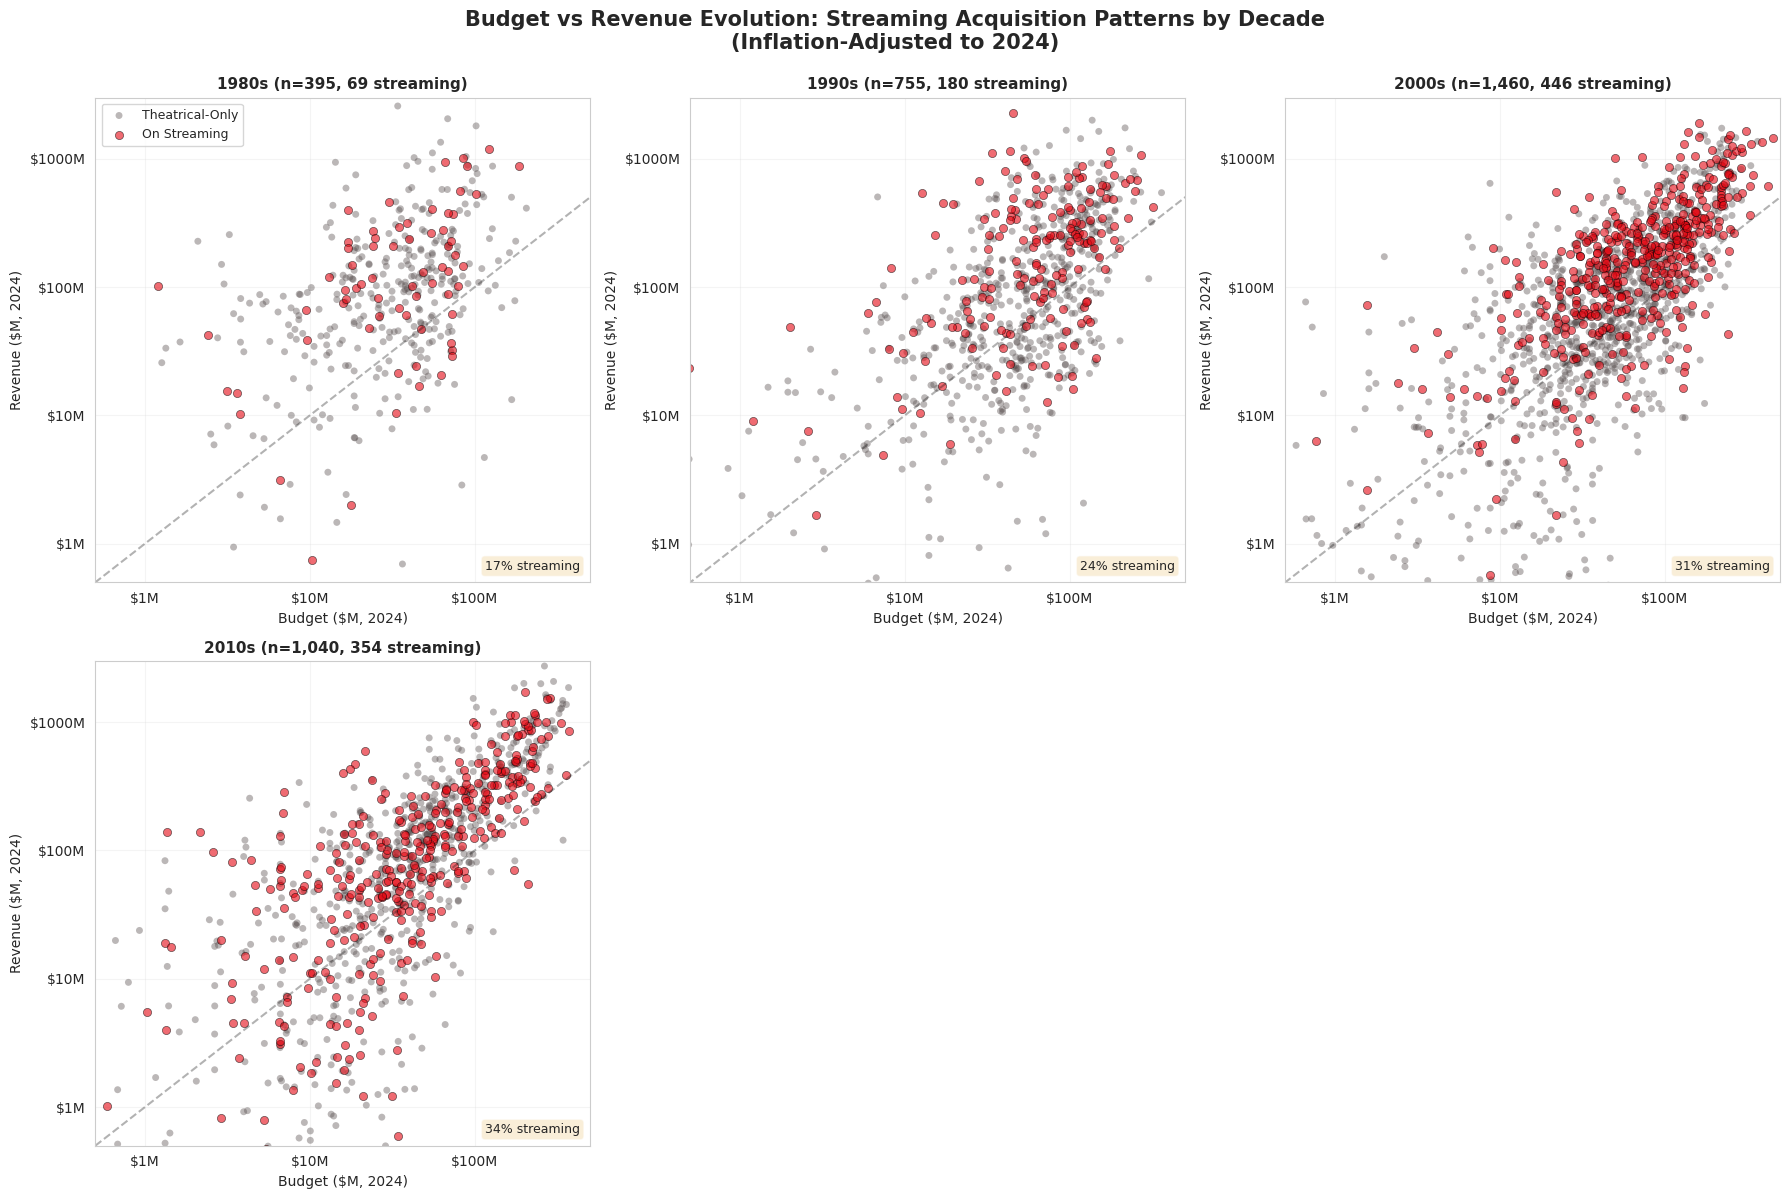


=== Streaming Acquisition by Decade ===

1980s:
  Total movies: 395
  Streaming: 69 (17.5%)
  Median budget (streaming): $38.1M
  Median budget (theatrical): $34.6M
  Median ROI (streaming): 370.0%
  Median ROI (theatrical): 182.6%

1990s:
  Total movies: 755
  Streaming: 180 (23.8%)
  Median budget (streaming): $63.5M
  Median budget (theatrical): $52.8M
  Median ROI (streaming): 165.3%
  Median ROI (theatrical): 74.6%

2000s:
  Total movies: 1,460
  Streaming: 446 (30.5%)
  Median budget (streaming): $71.0M
  Median budget (theatrical): $41.5M
  Median ROI (streaming): 132.2%
  Median ROI (theatrical): 49.2%

2010s:
  Total movies: 1,040
  Streaming: 354 (34.0%)
  Median budget (streaming): $38.4M
  Median budget (theatrical): $33.7M
  Median ROI (streaming): 115.6%
  Median ROI (theatrical): 112.3%


In [13]:
# Faceted Plot - Budget vs Revenue by Decade (colored by streaming status)

# Filter to movies with complete financial data
financial_df = xmdb_df[xmdb_df['budget_adj_2024'].notna() & xmdb_df['revenue_adj_2024'].notna()].copy()

# Create decade bins
financial_df['decade'] = (financial_df['release_year'] // 10) * 10
financial_df['decade_label'] = financial_df['decade'].astype(str) + 's'

# Focus on decades with sufficient data (1980s onward)
financial_df = financial_df[financial_df['decade'] >= 1980].copy()

print(f"Analyzing {len(financial_df):,} movies from 1980-2015")
print(f"Decades: {sorted(financial_df['decade'].unique())}")

# Create faceted plot
decades = sorted(financial_df['decade'].unique())
n_decades = len(decades)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, decade in enumerate(decades):
    ax = axes[idx]
    decade_data = financial_df[financial_df['decade'] == decade]
    
    # Plot theatrical-only (behind)
    theatrical = decade_data[~decade_data['on_streaming']]
    ax.scatter(theatrical['budget_adj_2024'] / 1e6,
               theatrical['revenue_adj_2024'] / 1e6,
               alpha=0.4, s=25, color='#564d4d', label='Theatrical-Only',
               edgecolors='none')
    
    # Plot streaming (on top)
    streaming = decade_data[decade_data['on_streaming']]
    ax.scatter(streaming['budget_adj_2024'] / 1e6,
               streaming['revenue_adj_2024'] / 1e6,
               alpha=0.6, s=35, color='#E50914', label='On Streaming',
               edgecolors='black', linewidths=0.5)
    
    # Break-even line
    max_val = max(decade_data['budget_adj_2024'].max(), decade_data['revenue_adj_2024'].max()) / 1e6
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1.5)
    
    # Formatting
    ax.set_title(f"{int(decade)}s (n={len(decade_data):,}, "f"{len(streaming):,} streaming)", fontsize=11, fontweight='bold')
    ax.set_xlabel('Budget ($M, 2024)', fontsize=10)
    ax.set_ylabel('Revenue ($M, 2024)', fontsize=10)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(0.5, 500)
    ax.set_ylim(0.5, 3000)
    ax.grid(alpha=0.2)
    
    ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    if idx == 0:
        ax.legend(fontsize=9, loc='upper left')
    
    # Add streaming percentage annotation
    streaming_pct = len(streaming) / len(decade_data) * 100 if len(decade_data) > 0 else 0
    
    ax.text(0.98, 0.02, f'{streaming_pct:.0f}% streaming', transform=ax.transAxes, ha='right', va='bottom',
            fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Hide extra subplots
for idx in range(n_decades, 6):
    axes[idx].set_visible(False)

plt.suptitle('Budget vs Revenue Evolution: Streaming Acquisition Patterns by Decade\n(Inflation-Adjusted to 2024)',
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Decade-by-decade statistics
print("\n=== Streaming Acquisition by Decade ===")
for decade in decades:
    decade_data = financial_df[financial_df['decade'] == decade]
    streaming = decade_data[decade_data['on_streaming']]
    theatrical = decade_data[~decade_data['on_streaming']]
    
    streaming_pct = len(streaming) / len(decade_data) * 100 if len(decade_data) > 0 else 0
    
    print(f"\n{int(decade)}s:")
    print(f"  Total movies: {len(decade_data):,}")
    print(f"  Streaming: {len(streaming):,} ({streaming_pct:.1f}%)")
    print(f"  Median budget (streaming): ${streaming['budget_adj_2024'].median()/1e6:.1f}M" if len(streaming) > 0 else "  No streaming data")
    print(f"  Median budget (theatrical): ${theatrical['budget_adj_2024'].median()/1e6:.1f}M")
    print(f"  Median ROI (streaming): {streaming['roi'].median():.1f}%" if len(streaming) > 0 and streaming['roi'].notna().sum() > 0 else "  No ROI data")
    print(f"  Median ROI (theatrical): {theatrical['roi'].median():.1f}%" if theatrical['roi'].notna().sum() > 0 else "  No ROI data")

---

**Observations:** The faceted scatter plots reveal that streaming platforms have progressively increased their acquisition rates with each decade, but their financial selectivity strategy has remained remarkably consistent over 35 years.

**Key Findings:**

1. Streaming acquisition rates have doubled from the 1980s to 2010s. This represents a 94% increase in acquisition rate from the 1980s to 2010s, demonstrating that streaming platforms aggressively license more recent content:
    - 1980s: 17.5% of theatrical releases on streaming (69 of 395 movies)
    - 1990s: 23.8% on streaming (180 of 755 movies)
    - 2000s: 30.5% on streaming (446 of 1,460 movies)
    - 2010s: 34.0% on streaming (354 of 1,040 movies)
2. Visual dominance shift - the progression is striking:
    - 1980s panel: Sparse red dots among dominant gray (theatrical-only)
    - 1990s panel: Red dots becoming more prominent but still minority
    - 2000s panel: Red dots achieving near-parity with gray
    - 2010s panel: Red dots absolutely dominating the visual space—nearly every successful movie is on streaming
3. Despite the 35-year span, streaming platforms show remarkably stable budget preferences. All streaming medians hover in the \\$38M-\\$71M range, demonstrating a consistent "mid-budget winner" strategy that transcends decades. The slight dip in the 2010s (\\$38M) may reflect streaming platforms beginning to license smaller successful films.
    - 1980s: \\$38.1M median streaming budget
    - 1990s: \\$63.5M median streaming budget
    - 2000s: \\$71.0M median streaming budget
    - 2010s: \\$38.4M median streaming budget
4. A fascinating pattern emerges when comparing streaming vs theatrical-only ROI across decades suggesting two possibilities: 1) streaming platforms are licensing broader slices of recent releases (not just cherry-picking super-winners) or 2) theatrical-only releases in recent decades are higher quality on average.
    - 1980s: Streaming advantage is massive (370% vs 183% = 187-point gap)
    - 1990s: Gap narrows (165% vs 75% = 90-point gap)
    - 2000s: Gap narrows further (132% vs 49% = 83-point gap)
    - 2010s: Gap nearly disappears (116% vs 112% = 4-point gap)
5. The 2000s panel shows the most dramatic visual change—red dots (streaming) achieve critical mass for the first time, occupying nearly equal space with gray dots. This decade marks streaming's transition from niche (licensing old classics) to mainstream (competing for recent hits).
6.  Across all four decades, red dots (streaming) cluster above the diagonal break-even line more densely than gray dots. Even in the 1980s, when streaming licensed only 17.5% of releases, they avoided flops. This multi-decade pattern confirms streaming's cherry-picking isn't a recent phenomenon - it's been the strategy since platforms began licensing theatrical content.

 **Conclusion:** Streaming platforms exhibit temporal escalation (licensing 2x more of each decade than the previous) combined with strategic consistency (always targeting mid-budget winners with proven ROI). The 2010s represent streaming's "conquest decade" - licensing over one-third of all theatrical releases, a rate that will likely increase further in the 2020s as streaming becomes the dominant distribution channel.

>**Question 7:** Do ratings predict ROI, and does this relationship differ between streaming and theatrical-only releases?
>
>**Hypothesis:** Higher-rated movies should achieve better ROI due to positive word-of-mouth and sustained audience interest.

Analyzing 3,854 movies with complete ROI, rating, and vote data


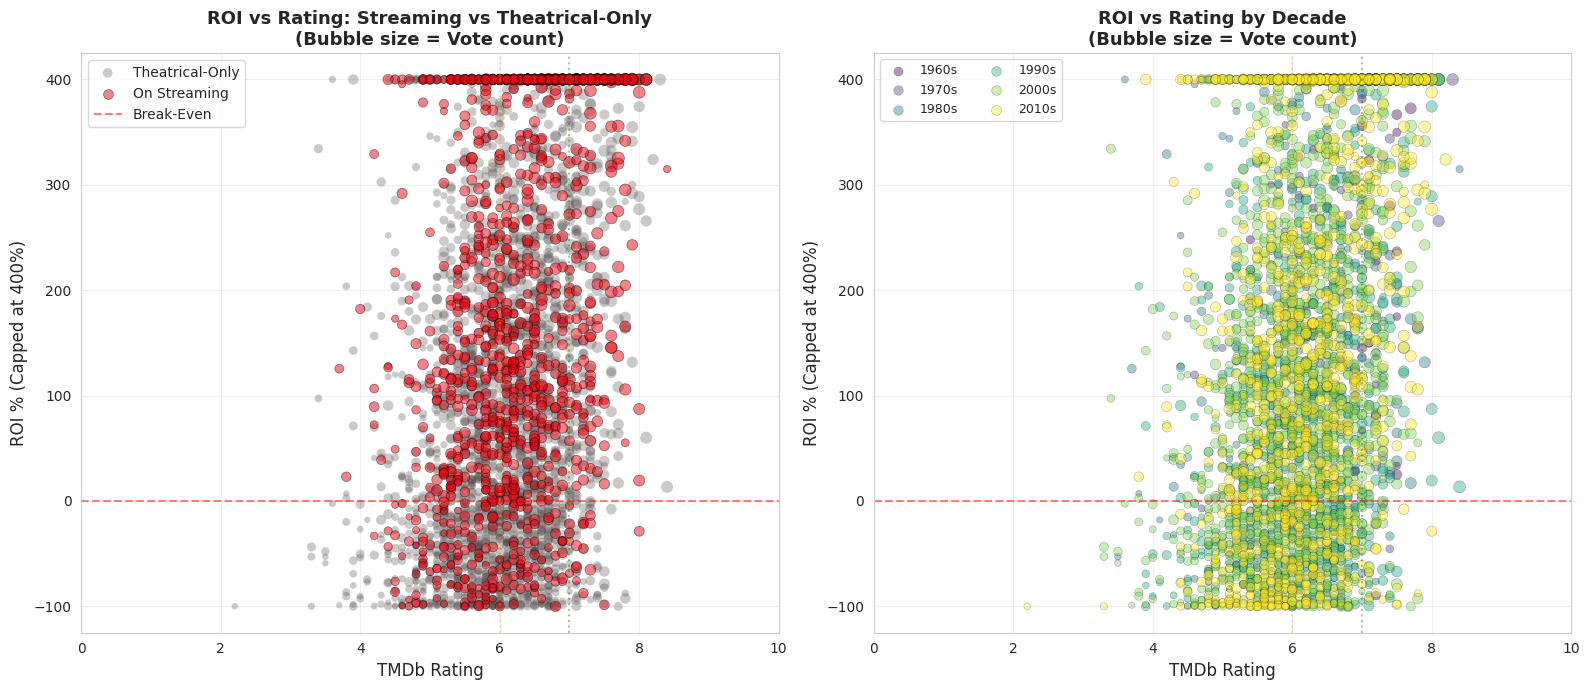


=== ROI vs Rating Correlation ===
Overall correlation (ROI vs Rating): -0.008
Streaming correlation: -0.017
Theatrical-only correlation: 0.001

=== Rating Brackets Analysis ===

Low (0-6.0):
  Total movies: 1,457
  On streaming: 406 (27.9%)
  Median ROI: 40.1%

Mid (6.0-7.0):
  Total movies: 1,764
  On streaming: 472 (26.8%)
  Median ROI: 128.4%

High (7.0+):
  Total movies: 633
  On streaming: 212 (33.5%)
  Median ROI: 298.6%


In [14]:
# Scatterplot with multiple encodings - ROI vs Rating
# (Color = streaming status, Size = vote count, Alpha = decade)

# Filter to movies with complete data
multi_df = xmdb_df[
    xmdb_df['roi'].notna() & 
    xmdb_df['tmdb_rating'].notna() &
    xmdb_df['tmdb_votes'].notna()
].copy()

# Create decade for color variation
multi_df['decade'] = (multi_df['release_year'] // 10) * 10

print(f"Analyzing {len(multi_df):,} movies with complete ROI, rating, and vote data")

# Cap ROI for visibility
multi_df['roi_capped'] = multi_df['roi'].clip(upper=400)

# Create size variable (scaled vote counts)
# Log scale the votes for better size differentiation
multi_df['size'] = np.log10(multi_df['tmdb_votes'] + 1) * 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# LEFT PLOT: Color by streaming status, size by votes
streaming = multi_df[multi_df['on_streaming']]
theatrical = multi_df[~multi_df['on_streaming']]

# Plot theatrical-only
ax1.scatter(theatrical['tmdb_rating'], 
           theatrical['roi_capped'],
           s=theatrical['size'],
           alpha=0.3,
           color='#564d4d',
           label='Theatrical-Only',
           edgecolors='none')

# Plot streaming
ax1.scatter(streaming['tmdb_rating'],
           streaming['roi_capped'],
           s=streaming['size'],
           alpha=0.5,
           color='#E50914',
           label='On Streaming',
           edgecolors='black',
           linewidths=0.5)

ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5, label='Break-Even')
ax1.set_xlabel('TMDb Rating', fontsize=12)
ax1.set_ylabel('ROI % (Capped at 400%)', fontsize=12)
ax1.set_title('ROI vs Rating: Streaming vs Theatrical-Only\n(Bubble size = Vote count)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.set_xlim(0, 10)

# Add rating threshold lines
ax1.axvline(x=6.0, color='orange', linestyle=':', alpha=0.4, linewidth=1.5)
ax1.axvline(x=7.0, color='green', linestyle=':', alpha=0.4, linewidth=1.5)

# RIGHT PLOT: Same but colored by decade (shows temporal patterns)
decades = sorted(multi_df['decade'].unique())
decade_colors = plt.cm.viridis(np.linspace(0, 1, len(decades)))

for idx, decade in enumerate(decades):
    decade_data = multi_df[multi_df['decade'] == decade]
    ax2.scatter(decade_data['tmdb_rating'],
               decade_data['roi_capped'],
               s=decade_data['size'],
               alpha=0.4,
               color=decade_colors[idx],
               label=f"{int(decade)}s",
               edgecolors='black',
               linewidths=0.3)

ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
ax2.set_xlabel('TMDb Rating', fontsize=12)
ax2.set_ylabel('ROI % (Capped at 400%)', fontsize=12)
ax2.set_title('ROI vs Rating by Decade\n(Bubble size = Vote count)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=9, loc='upper left', ncol=2)
ax2.grid(alpha=0.3)
ax2.set_xlim(0, 10)

# Add rating threshold lines
ax2.axvline(x=6.0, color='orange', linestyle=':', alpha=0.4, linewidth=1.5)
ax2.axvline(x=7.0, color='green', linestyle=':', alpha=0.4, linewidth=1.5)

plt.tight_layout()
plt.show()

# Statistical analysis
print("\n=== ROI vs Rating Correlation ===")
print(f"Overall correlation (ROI vs Rating): {multi_df['roi'].corr(multi_df['tmdb_rating']):.3f}")
print(f"Streaming correlation: {streaming['roi'].corr(streaming['tmdb_rating']):.3f}")
print(f"Theatrical-only correlation: {theatrical['roi'].corr(theatrical['tmdb_rating']):.3f}")

print("\n=== Rating Brackets Analysis ===")
brackets = [
    ("Low (0-6.0)", 0, 6.0),
    ("Mid (6.0-7.0)", 6.0, 7.0),
    ("High (7.0+)", 7.0, 10.0)
]

for bracket_name, min_rating, max_rating in brackets:
    bracket_data = multi_df[
        (multi_df['tmdb_rating'] >= min_rating) & 
        (multi_df['tmdb_rating'] < max_rating)
    ]
    streaming_bracket = bracket_data[bracket_data['on_streaming']]
    
    streaming_pct = len(streaming_bracket) / len(bracket_data) * 100 if len(bracket_data) > 0 else 0
    median_roi = bracket_data['roi'].median()
    
    print(f"\n{bracket_name}:")
    print(f"  Total movies: {len(bracket_data):,}")
    print(f"  On streaming: {len(streaming_bracket):,} ({streaming_pct:.1f}%)")
    print(f"  Median ROI: {median_roi:.1f}%")

---

**Observations:** The dual scatter plots reveal a shocking disconnect - critical acclaim shows virtually zero correlation with profitability (r = -0.008), yet streaming platforms strongly prefer highly-rated films. This paradox exposes the complexity of streaming curation strategies.

**Key Findings:**

1. Zero correlation, yet clear pattern. The correlation statistics tell one story, but the median analysis reveals a different truth. This apparent contradiction occurs because while averages show little relationship (due to massive variance at every rating level), the medians show clear improvement with higher ratings. High-rated films have fewer catastrophic flops pulling down their averages.
    - Overall: r = -0.008 (no relationship)
    - Streaming: r = -0.017 (no relationship)
    - Theatrical-only: r = 0.001 (no relationship)
    - Low-rated (0-6.0): 40.1% median ROI
    - Mid-rated (6.0-7.0): 128.4% median ROI
    - High-rated (7.0+): 298.6% median ROI
2. Streaming prefers quality. Despite ratings not predicting individual movie ROI, streaming platforms show clear quality bias in licensing. Streaming platforms license 20% more high-rated content than low-rated (33.5% vs 27.9%), suggesting they use ratings as a risk filter even though ratings don't guarantee profit.
    - High-rated films (7.0+): 33.5% on streaming
    - Mid-rated films (6.0-7.0): 26.8% on streaming
    - Low-rated films (0-6.0): 27.9% on streaming
3. The left panel dramatically shows red dots (streaming) clustering above the break-even line at all rating levels, while gray dots spread evenly above and below. This proves streaming's cherry-picking extends across the quality spectrum - they license winners in both highbrow (7.0+ rated) and lowbrow (5.0-6.0 rated) categories.
4. Vote count reveals audience engagement. Bubble size (vote count) shows a clear pattern - larger bubbles cluster in the profitable zone (ROI > 100%). This suggests:
    - Popular movies (high vote counts) tend to be profitable
    - But popularity != critical acclaim (many large bubbles at 6.0-6.5 ratings)
    - Streaming platforms may prioritize engagement metrics over critics' scores
5. The temporal pattern (right panel): Recent decades (yellow/green 2000s-2010s) dominate the visual space but spread across all rating levels. This shows:
    - Recent movies aren't inherently higher-rated than classics
    - But they are more likely to be on streaming (recency bias from earlier analysis)
    - The 1960s-1980s (dark purple dots) cluster in the 6.0-7.5 rating range, suggesting survivorship bias - only well-regarded classics from these decades remain in streaming catalogs
6. Notice the horizontal band at 400% ROI - this is our cap for visibility. Many movies exceed this (visible in statistics with 298.6% median for high-rated films), but extreme outliers (5,000%+ ROI) would compress the visualization. These "lottery ticket" successes (typically low-budget horror or indie breakouts) occur at all rating levels, explaining the zero correlation.

The left panel's pattern is clear but counterintuitive:

- Vertical spread at every rating: From 4.0 to 8.0, movies achieve ROI anywhere from -100% to 400%
- Red concentration above zero: Streaming dots avoid the loss zone more effectively than theatrical-only
- No upward slope: The cloud doesn't tilt right (which would indicate higher ratings lead to higher ROI)

The right panel shows temporal layering:

- Yellow/green (recent) fill the entire space - low and high ratings, successes and failures
- Purple/dark blue (old) concentrate in the 6.0-7.5 "classics" zone - failures from these decades didn't survive into streaming

Three factors explain the paradox:

- Marketing overwhelms quality. A mediocre movie (6.0 rating) with \\$100M marketing budget outperforms an excellent movie (8.0 rating) with \\$5M marketing
- Genre effects. Action blockbusters (6.5 average rating) earn more than art films (7.5 rating) due to broader appeal
- Budget mismatch. Low-budget successes achieve 1,000%+ ROI even with mediocre ratings (6.0), while expensive flops lose money despite good ratings (7.0)


 **Conclusion:** Streaming platforms face a double optimization problem - they must select movies that are both profitable (high ROI) and appealing (high ratings) to attract subscribers. The 33.5% licensing rate for high-rated films vs 27.9% for low-rated proves they hedge toward quality, but the zero correlation proves ratings alone don't guarantee financial success. Streaming curation likely combines multiple signals: ratings, budget, genre, cast, and proven box office performance—no single metric suffices.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The multivariate exploration revealed how temporal, financial, and quality dimensions interact with streaming availability:

1. Decade amplifies streaming penetration. The faceted budget-revenue plots showed streaming acquisition rates doubling from 17.5% (1980s) to 34.0% (2010s), but the financial selectivity pattern remained constant across all decades - streaming always targets mid-budget winners (\\$38M-\\$71M), regardless of era.
2. Rating moderates streaming preference. The ROI-rating scatterplot revealed that while individual ratings don't predict ROI (r = -0.008), streaming platforms license 20% more high-rated content (33.5% vs 27.9% for low-rated). This suggests platforms use ratings as a risk filter rather than a profit predictor - high ratings reduce downside risk even if they don't guarantee upside.
3. Vote count strengthens ROI signal. Bubble size (vote counts) showed clear clustering in the profitable zone - popular movies (high engagement) tend to be profitable AND more likely to be on streaming. This three-way relationship (engagement → profit → streaming) suggests platforms prioritize audience-validated hits over critics' favorites.
4. Decade × Rating reveals survivorship. The temporal scatterplot showed older decades (1960s-1980s) clustering in the 6.0-7.5 'classics' range, while recent decades spread across all ratings. This interaction proves streaming catalogs exhibit quality survivorship bias - only well-regarded films from distant decades survive into licensing, while recent decades include both hits and misses.

### Were there any interesting or surprising interactions between features?

Several counterintuitive interactions emerged:

1. Streaming's ROI advantage shrank dramatically from 187 percentage points (1980s: 370% vs 183%) to just 4 points (2010s: 116% vs 112%). This decade × streaming × ROI interaction suggests either (a) platforms are broadening their recent acquisitions beyond super-winners, or (b) theatrical-only 2010s releases haven't yet aged enough for failures to drop out of circulation.
2. Despite zero correlation between rating and ROI overall (r = -0.008), streaming movies at every rating level cluster above break-even more than theatrical-only. This three-way interaction (rating × ROI × streaming) proves platforms don't use ratings to predict profit, but rather to filter out proven losers - they license profitable movies across the quality spectrum (both 6.0-rated crowd-pleasers and 8.0-rated prestige films).
3. Despite 35 years of cinema evolution (blockbuster era, franchise dominance, CGI revolution), streaming's median budget target remained remarkably stable (\\$38M-\\$71M). The decade × budget × streaming interaction shows platforms consistently avoid both ultra-low-budget (<\\$5M) and mega-blockbusters (>\\$200M), suggesting a strategic 'Goldilocks zone' that transcends temporal trends.

## Conclusions

### Summary of Main Findings

This exploratory analysis investigated whether movies that ended up on streaming platforms differ systematically from theatrical-only releases. Through univariate, bivariate, and multivariate visualizations, clear patterns emerged that reveal strategic curation by streaming platforms.

**Key Discoveries:**

1. **Streaming exhibits extreme recency bias:** 72% of streaming movies come from the 2000s-2010s, with the 2010-2015 period alone accounting for 38.9% of all streaming content. Pre-1990 films represent only 11.9% of streaming catalogs despite comprising 33% of theatrical releases in the dataset.

2. **Streaming platforms cherry-pick financial winners:** streaming platforms license proven successes, not bargain-bin content or theatrical failures. Movies on streaming have:
   - 38% higher median budgets (\\$54.3M vs \\$39.4M)
   - 93% higher median revenues (\\$139.7M vs \\$72.3M)
   - 51-percentage-point higher median ROI (145.9% vs 94.9%)
   - 42% lower failure rate (18.2% vs 31.6% losing money)

3. **Platforms operate with near-total exclusivity:** 93.5% of streaming movies appear on only one platform, with just 6.2% on two platforms and 0.3% on three platforms. No theatrical release appears on all four platforms, demonstrating fierce competition for exclusive content.

4. **Genre specialization reveals competitive positioning:** drama is universal (#1 on all platforms at 16-18%), but secondary genres reveal strategic differentiation.
   - **Disney+** dominates family content (23.8% of catalog, 58.8% market share)
   - **Netflix** leads by volume across all genres (40-52% market shares)
   - **Hulu** carves a thriller/action niche (13.5% thriller focus)
   - **Amazon** emphasizes drama (18.1% of catalog)

5. **Temporal escalation with strategic consistency:** Streaming acquisition rates doubled from 17.5% (1980s) to 34.0% (2010s), yet median budget targets remained stable (\\$38M-\\$71M) across all decades. This reveals platforms aggressively expand volume while maintaining consistent financial selectivity.

6. **The rating-ROI paradox:** Despite near-zero correlation between ratings and ROI (r = -0.008), streaming platforms license 20% more high-rated content (33.5% for 7.0+ vs 27.9% for 0-6.0). This suggests ratings serve as a risk filter rather than a profit predictor - platforms hedge toward quality to reduce downside risk.

7. **The mid-budget "Goldilocks zone":** Streaming acquisitions concentrate in \\$30M-\\$100M budgets, avoiding both ultra-low-budget (<\\$5M) and mega-blockbusters (>$200M). This sweet spot balances production value (appealing to subscribers) with licensing costs (affordable at scale).

### Reflection on the Data Exploration Process

**Methodological Strengths:**

- **Clean foundation:** The dataset was pre-wrangled in Project 2, allowing immediate focus on visualization and pattern discovery rather than data quality issues.
- **Systematic progression:** Following the univariate → bivariate → multivariate framework revealed patterns incrementally, with each section building on insights from the previous.
- **Multiple perspectives:** Using different visualization types (scatter plots, box plots, heatmaps, faceted plots) on similar questions revealed complementary insights. For example, the scatter plot showed streaming's budget clustering, while box plots quantified the exact ROI advantage.

**Unexpected Findings:**

- **The ROI advantage was surprising:** Initial hypothesis suggested streaming platforms might license cheap failures (bargain content), but data showed the opposite - they license expensive winners.
- **The rating-ROI disconnect was counterintuitive:** Expected strong correlation between critical acclaim and profit, but found essentially zero correlation (r = -0.008). This revealed the complexity of movie economics where marketing, genre, and timing overwhelm quality signals.
- **Genre monopolies were more extreme than anticipated:** Disney's 58.8% control of Family content and Netflix's 40-52% dominance across most genres demonstrate winner-take-all dynamics in streaming more stark than traditional media.

**Limitations and Future Directions:**

- **Survivorship bias in older decades:** The 1980s-1990s streaming catalogs likely over-represent classics (6.0-7.5 rated films), as forgotten flops from these decades were never licensed. This makes temporal comparisons somewhat misleading.
- **Causality ambiguity:** High ROI for streaming movies could indicate either (a) platforms cherry-pick winners, or (b) streaming distribution itself boosts a film's total revenue. Distinguishing these mechanisms would require controlled experiments or instrumental variables.
- **Missing variables:** The analysis lacked data on licensing costs, streaming viewership metrics, and subscriber acquisition tied to specific titles. These would reveal whether platforms' strategies actually maximize ROI or if other objectives (brand positioning, contract negotiations) drive decisions.

**Transition to Explanatory Analysis:**

The exploratory phase identified several compelling stories that warrant polished communication:
1. **The temporal surge:** Streaming's progression from 17.5% (1980s) to 34% (2010s) acquisition
2. **Platform personalities:** Disney's family monopoly vs Netflix's volume strategy
3. **The cherry-picking evidence:** Financial advantages across budget, revenue, and ROI

Part II will transform the most impactful exploratory visualizations into explanatory plots that communicate these findings to a general audience, focusing on the overarching narrative: **Streaming platforms don't rescue failures - they license winners.**